In [59]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend
from IPython.display import clear_output
from scipy.interpolate import CubicSpline

from utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [2]:
def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    return fig, ax

def plot_alpha_mean_all(obj, use_density_fit = True, act_idx_bounds = None,):
    

    suffix = 'dens' if use_density_fit else 'count'

    fig, ax = plt.subplots(figsize=(9, 6))
    marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

    for i, LX in enumerate(obj.LX):
        act_list = obj.act_list[i]

        try:
            alpha_list = np.load(os.path.join(obj.inputs_paths[i], f'alpha_list_{suffix}.npy'))
        except:
            print('Alpha list not found. Analyse hyperuniformity first.')
            return
        try:
            alpha_list_sfac_time_av = np.load(os.path.join(obj.inputs_paths[i], f'fit_params_sfac_time_av.npy'))[:,[0,2]]
        except:
            print('Alpha list not found. Analyse sfac first.')
            return
        
        act_idx_bounds = [0, None] if act_idx_bounds is None else act_idx_bounds
        act_list = np.array(act_list[act_idx_bounds[0]:act_idx_bounds[1]])

        alpha_list_sfac_time_av = alpha_list_sfac_time_av[act_idx_bounds[0]:act_idx_bounds[1]]
        alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

        ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                label = f'L = {obj.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')

        ax.errorbar(act_list, alpha_list_sfac_time_av[:, 0], alpha_list_sfac_time_av[:, 1], fmt = marker_shape[2], \
                        alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
    ax.legend()
    ax.set_xlabel(r'$\zeta$')
    ax.set_ylabel(rf'$\langle\alpha \rangle$')
    ax.set_title(rf'Time av. of $\alpha $ vs activity')
    fig.tight_layout()
    return fig, ax

def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(1):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]
         #   print(i)
            print(fit_vals[:,0])
            print(fit_err[:,0])
            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)
            print("\n", i)
            print(alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
            print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_std / np.sqrt(fit_vals_valid.shape[0]), beta_std / np.sqrt(fit_vals_valid.shape[0]) #alpha_sem, beta_sem
   
    return fit_params_sfac_time_av

def analyze_sfac_interactive(kbins, sfac_av, act_idx=0, pval_min=0.05, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)

    fit_params_sfac_time_av = np.zeros([2 * Nparams]) * np.nan
    fit_params_unweighted = np.zeros([2 * Nparams]) * np.nan

    i = act_idx
    it_max = 15
    sfac_nan_mask = np.isnan(sfac_av[:, i, 0])
    try:
        x = np.log(kbins[~sfac_nan_mask])
        y = np.log(sfac_av[~sfac_nan_mask, i, 0])
        yerr = sfac_av[~sfac_nan_mask, i, 1] / sfac_av[~sfac_nan_mask, i, 0] 
    except:
        return None, None

    fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
    fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

        for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])): 
            it = 0        
            yerr_mod = yerr.astype(float)   
            while it < it_max:
                it += 1

                yerr_mod *= np.sqrt(it)
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr_mod[:Npoints_to_fit],
                                    param_guess, verbose = False)
                Ndof, chi2, pval = get_statistics_from_fit(fit, len(x[:Npoints_to_fit]), subtract_1dof_for_binning = False)
                
                if pval > pval_min:
                    fit_vals[j] = fit.values[:] 
                    fit_err[j] = fit.errors[:]
                    break

            print(f'it: {it}, Npoints: {Npoints_to_fit}, alpha: {fit.values[0]} +/- {fit.errors[0]}, chi2: {chi2}, pval: {pval}')
        
        nan_mask = np.isnan(fit_vals[:,0])
        fit_vals_valid = fit_vals[~nan_mask]
        fit_err_valid = fit_err[~nan_mask]
        Nfits_valid = fit_vals_valid.shape[0]

        if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
            return None, None

        if Nfits_valid == 1:
            fit_params_sfac_time_av[:Nparams] = fit_vals[0,:]
            fit_params_sfac_time_av[Nparams:] = fit_err[0,:]
            fit_params_unweighted = fit_params_sfac_time_av
        else:  
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_sem *= np.sqrt(Nfits_valid)
            beta_sem *= np.sqrt(Nfits_valid)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                fit_params_sfac_time_av[:Nparams] = alpha_weighted_av, beta_weighted_av
                fit_params_sfac_time_av[Nparams:] = alpha_sem, beta_sem
                fit_params_unweighted[:Nparams] = np.nanmean(fit_vals_valid, axis = 0)   
                fit_params_unweighted[Nparams:] = np.nanstd(fit_vals_valid, axis = 0)
    return fit_params_sfac_time_av, fit_params_unweighted

In [38]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

In [39]:
LL = 2048
output_path = f'data\\na{LL}'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

Text(0.02, 0.54, '$\\sim k^{0.2}$')

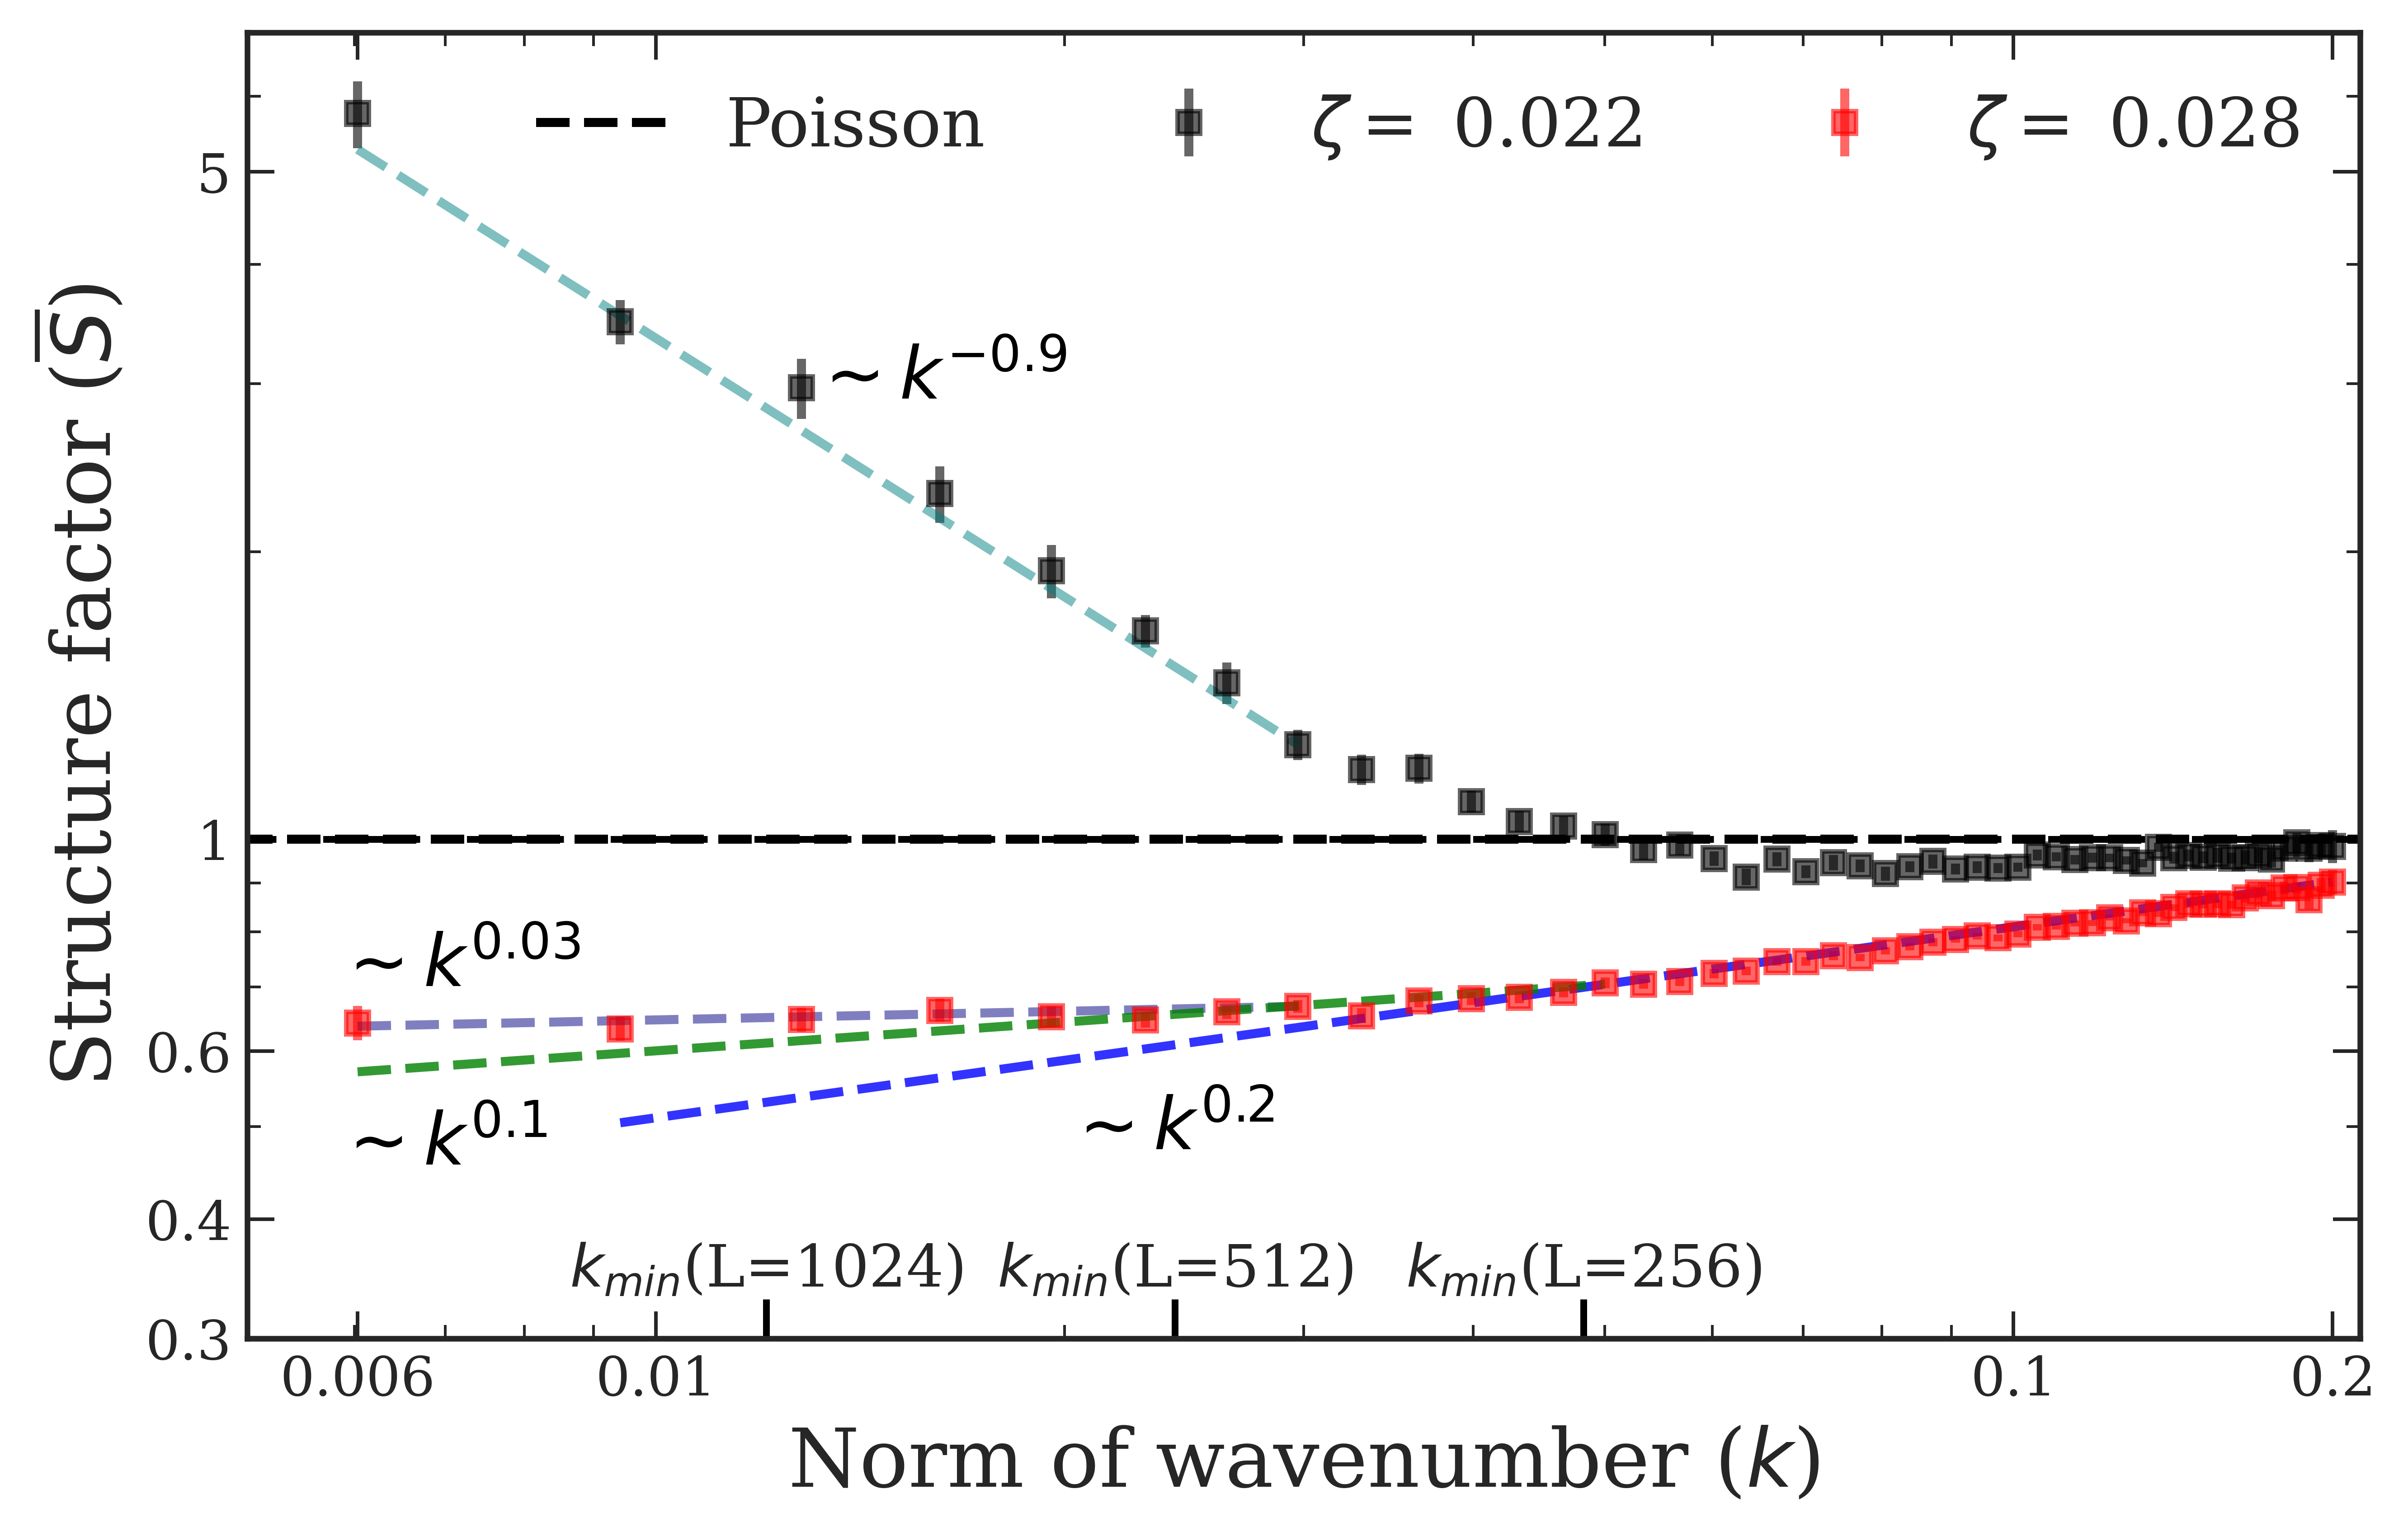

In [56]:
#kmin_list is the smallest k for each L
kmin_list = []
for L in ada.LX:
    kbins = ada.get_sfac(LX=L,time_av=True)[0]
    kmin_list.append(np.min(kbins))


ratio = 4.5 / 7
w = 7.5
h = w * ratio
fig, ax = plt.subplots(ncols=1,figsize=(w, h))
label_list = [r'$k^{-0.9}$', r'$k^{0.03}$']
scaling_exp_list = [float(label.split('{')[-1].split('}')[0]) for label in label_list]
axx = ada.plot_sfac_per_activity(LX = 2048, Npoints_to_fit=8, act_list=[0.022,0.028,], scaling_exp_list = scaling_exp_list, ax = ax)#act_list = [0.022, 0.024, 0.026, 0.027], weighted = True)
kbins, sfac_av = ada.get_sfac(LX=2048)[:2]

ax.set_ylabel(r'Structure factor ($\overline{S}$)')
axx.hlines(1, 0, 0.4, color = 'k', linestyle='--', lw=1.5)
axx.set_ylim([0.3, 7])
axx.set_xlim([0.005,0.18])
axx.legend(loc='upper right', ncol=2)
klabel_list = [r'$k_{min}$(L=256)', r'$k_{min}$(L=512)', r'$k_{min}$(L=1024)']
for i, kmin in enumerate(kmin_list[:-1]):
    axx.vlines(kmin, 0.3, .33, color = 'k', linestyle='-', lw=1.5)
    axx.text(kmin, 0.33, klabel_list[i], fontsize=13, verticalalignment='bottom', horizontalalignment='center')
#axx.text(0.7, 0.2, r'L = 1024', transform=axx.transAxes, fontsize=16, verticalalignment='top', fontweight='normal')
#axx.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

act_idx = ada.act_list[ada.LX.index(2048)].index(0.028)
x = kbins[1:50]
x2 = kbins[0:14]
scaling_exp = .2
scaling_exp2 = .1
axx.plot(x, (sfac_av[-1,act_idx,0]-0.00) * x**scaling_exp / x[-1]**scaling_exp, '--',lw=2, alpha=.8, color='blue')
axx.plot(x2, (sfac_av[len(x2),act_idx,0]+0.0) * x2**scaling_exp2 / x2[-1]**scaling_exp2, '--',lw=2, alpha=.8, color='green')
axx.legend(ncol=3)
fig.dpi = 720

ax.text(0.013, 3.3, r'$\sim k^{-0.9}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.0058, 0.8, r'$\sim k^{0.03}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.0058, 0.52, r'$\sim k^{0.1}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')
ax.text(0.02, 0.54, r'$\sim k^{0.2}$', fontsize=16, verticalalignment='top', fontweight='normal', color='k')

In [64]:
fit_params_of_av[:,0]

array([-4.72348734e-01, -1.57516554e-01, -1.55992148e-02, -3.41646101e-01,
       -8.64842565e-01, -8.91114303e-01, -2.88471822e-01, -1.80230015e-01,
       -5.91768816e-03, -5.17094240e-02,  2.27838613e-02,  2.10721464e-02,
        1.83809098e-02,             nan,  3.63746349e-03, -2.02262032e-04,
       -1.17126893e-02])

True
ndof chi2 prop:  2 0.07414552797312911 0.9636060169827652
k:  0.8515880294837577 +/- 0.3154487020875283
c:  -0.8798165712720472 +/- 0.08005021773456701


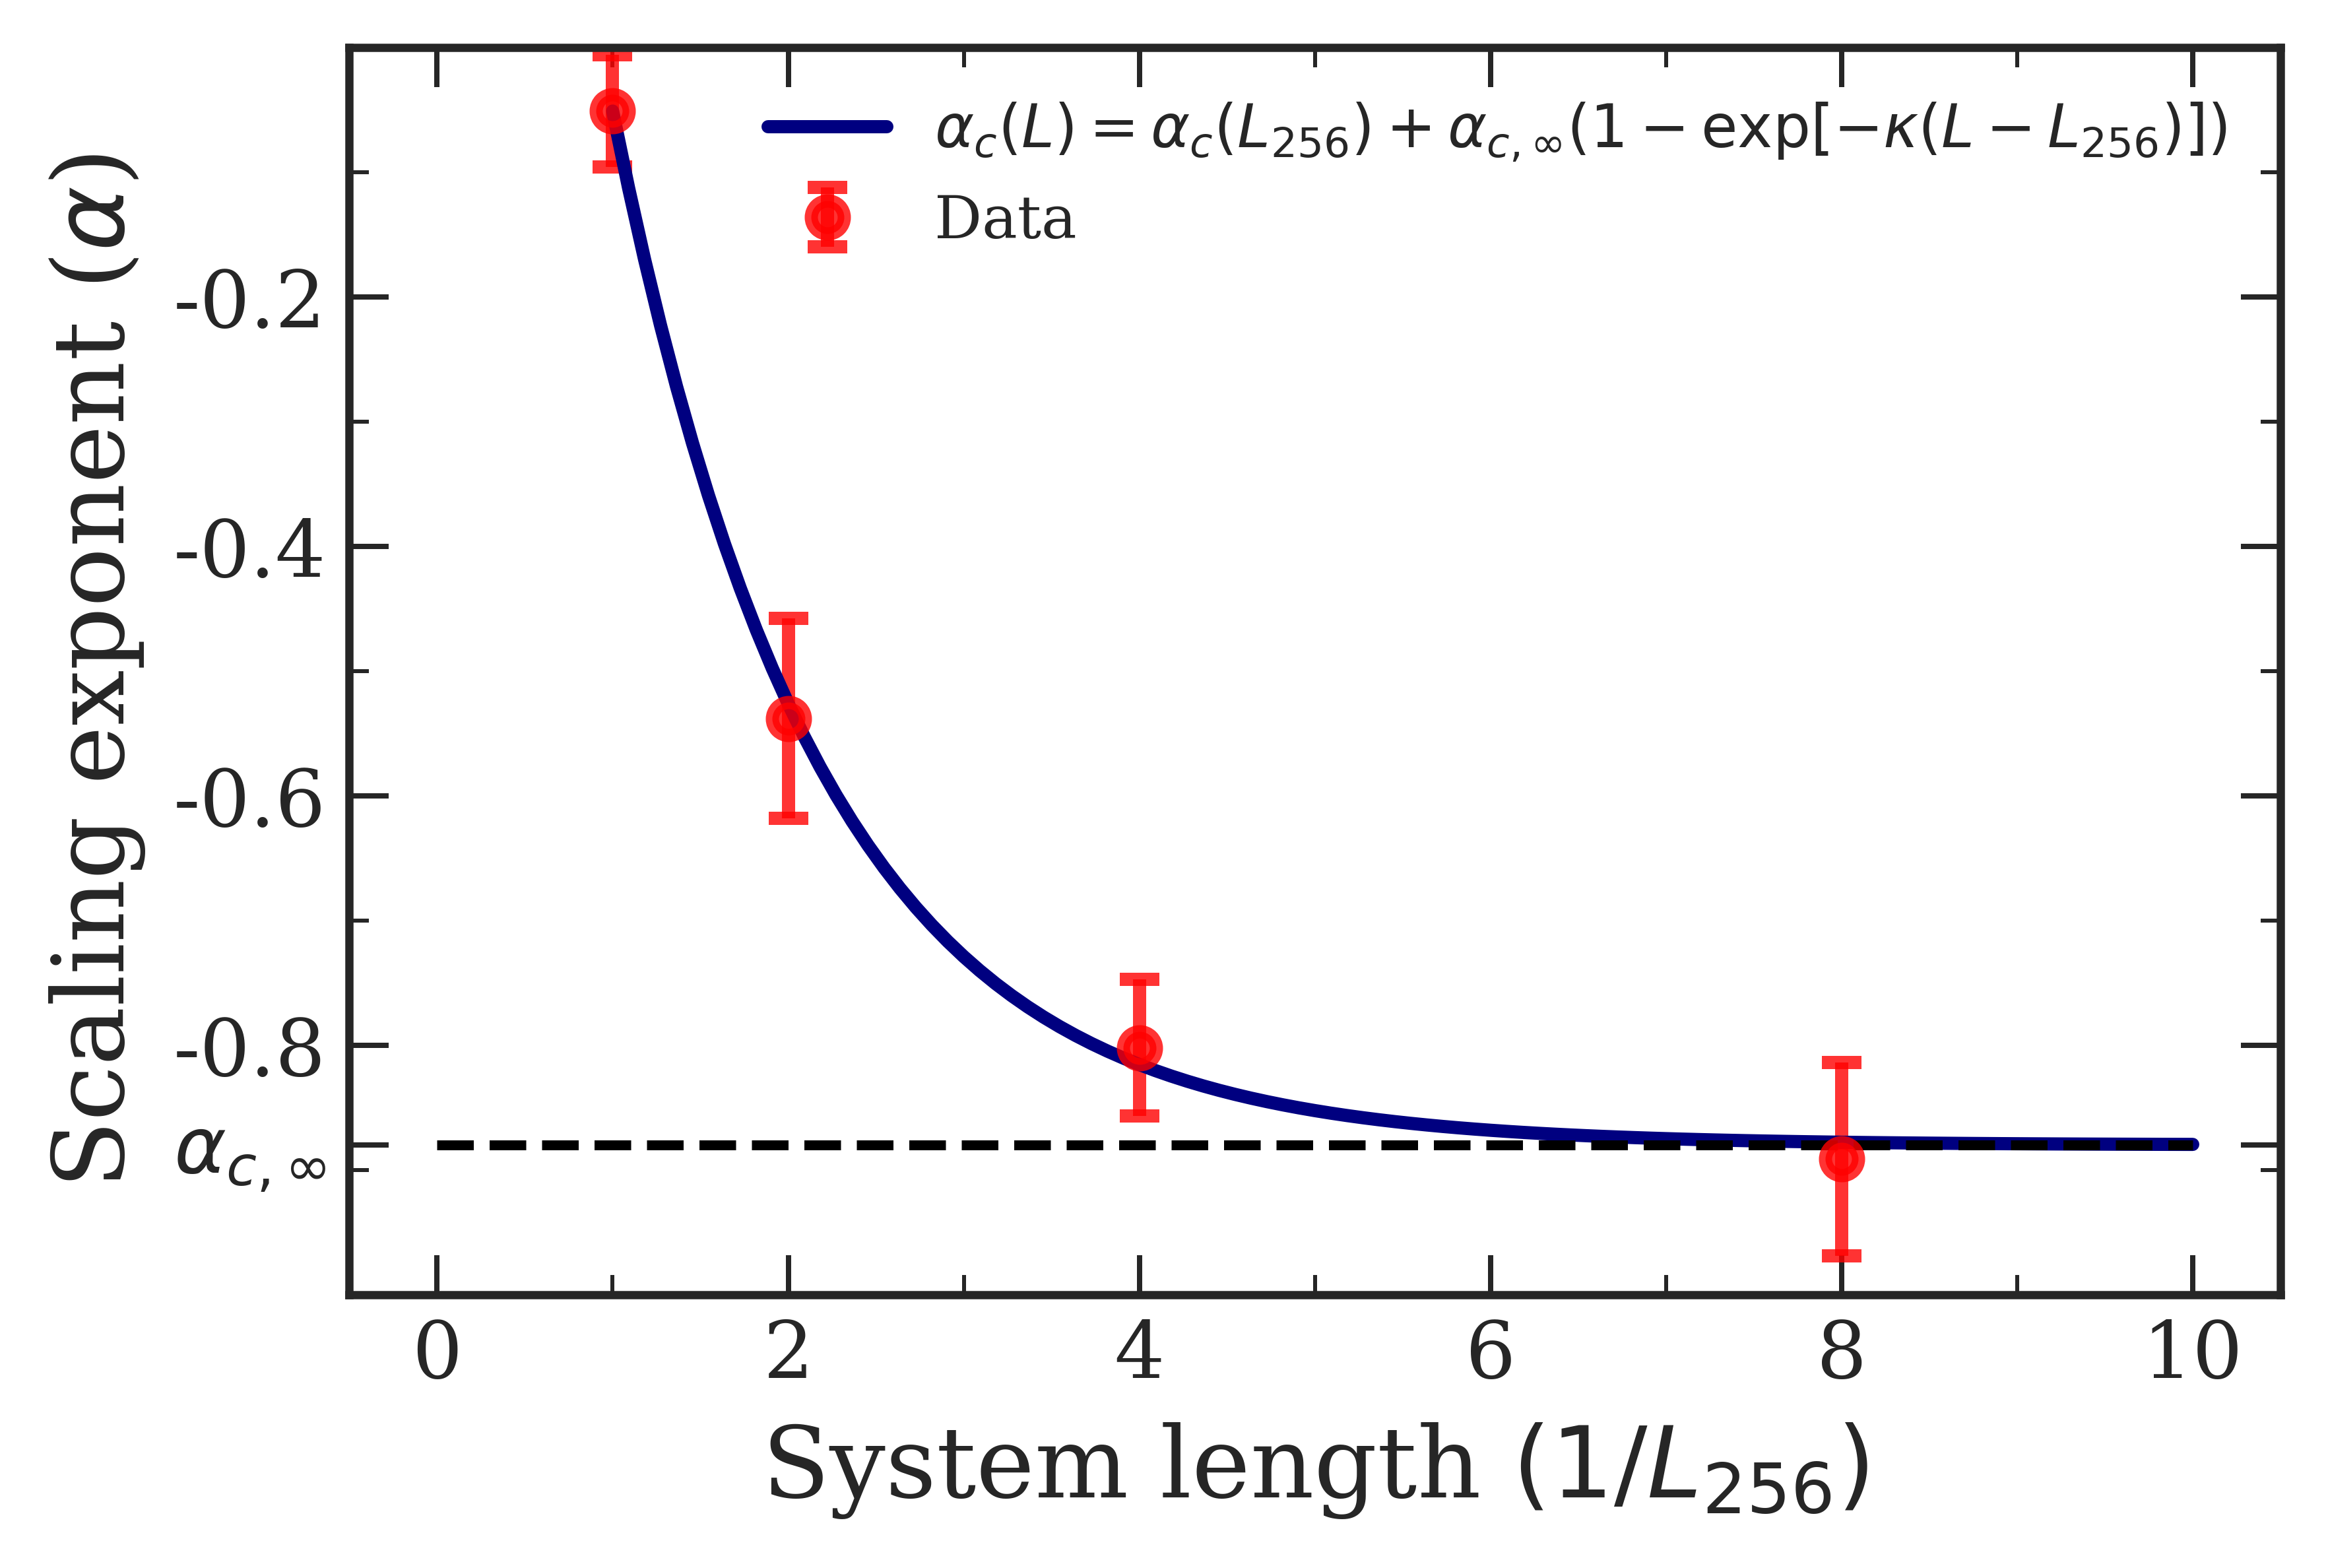

In [85]:


time_av_of_fits = False

av_of_fits, fit_params_of_av = ada.get_alpha(LX=2048)[:2]
fit_of_av = fit_params_of_av[:,[0,2]]
act_list = ada.act_list[ada.LX.index(2048)]

fig, ax = plt.subplots(figsize=(5,3.4))
min_syst_idx = 0
acts_to_plot = [0.022,]
alphas = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
alphas_err = np.zeros([len(acts_to_plot), len(ada.LX[min_syst_idx:])])
LX_list = ada.LX[min_syst_idx:]
for i, L in enumerate(ada.LX[min_syst_idx:]):
    act_list = ada.act_list[i+min_syst_idx]
    act_idx_list = [act_list.index(act) for act in acts_to_plot]
    av_of_fits, fit_params_of_av = ada.get_alpha(LX=L)[:2]
    alphas[:,i] = av_of_fits[act_idx_list,0] if time_av_of_fits else fit_params_of_av[act_idx_list,0] 
    alphas_err[:,i] = av_of_fits[act_idx_list,1] if time_av_of_fits else fit_params_of_av[act_idx_list,2]
norm = np.ones(4-min_syst_idx)#[1,1,1] #np.abs(alphas[:,0])
normx = LX_list[0]
LX_list_normed = [LX_list[i] / normx for i in range(4-min_syst_idx)]

for i in range(len(acts_to_plot)):
    X = np.array(LX_list_normed)
    Y = np.array(list(alphas[i]/norm[i]))
    dY = np.array(list(alphas_err[i]/norm[i]))
    cs = CubicSpline(X,Y, bc_type='natural')
    x = np.linspace(1,8,8)
    y = cs(x)
    dy = np.zeros_like(y)
    data_idx = [2, 4,5, 7]
    dy[[0, 1, 3, 7]] = dY
    zero_mask = (dy == 0)
    dy[zero_mask] = np.mean(dy[~zero_mask])


    ax.errorbar(X, Y, dY, fmt = 'o', label = rf'Data', color = 'red',\
            markersize = 5, alpha = .8, elinewidth = 2, capsize = 3, markeredgewidth = 2)

    x0 = 0.9

    fit_func_exp = lambda x, k, c: c * (1 - np.exp(-k*(x-1)))
    fit_label = r'$\alpha_c(L) = \alpha_c(L_{256}) + \alpha_{c,\infty}(1 - \exp[-\kappa(L - L_{256})])$'

    param_guess = [.5, -1,]
    point_bounds = [50,250]
    xlim = [0, 10]
    #ax.set(yticks = yticks, yticklabels = yticklabels, xlim=xlim)

    x_plot_fit = np.linspace(X[0],xlim[-1],100)
    fit_exp = do_chi2_fit(fit_func_exp, X, Y - Y[0], np.sqrt(dY**2 + dY[0]**2), param_guess, verbose = False)
    print(fit_exp._fmin.is_valid)

    yticks = [fit_exp.values['c'] + Y[0], -0.8, -0.6, -0.4, -0.2]
    yticklabels = [r'$\alpha_{c,\infty}$', -0.8, -0.6, -0.4, -0.2]
    ax.set_xlabel(r'System length $(1/L_{256})$', fontsize=15)
    ax.set_ylabel(r'Scaling exponent ($\alpha$)', fontsize=15)
    ax.plot(x_plot_fit, fit_func_exp(x_plot_fit, *fit_exp.values[:]) + Y[0], '-', color = 'navy', label = fit_label) # acts_to_plot[i]) #fit_label) #
  
    ax.set(yticks = yticks, yticklabels = yticklabels, ylim=[-1,0])#xlim=[0,40])
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.hlines(fit_exp.values['c'] + Y[0], 0,10, lw=1.5,color = 'black', linestyle = '--',)# label = rf'$\alpha_c = {(fit_exp.values["c"]+Y[0]):.2f}$')
    Ndof, chi2, prop = get_statistics_from_fit(fit_exp, len(X),)
    print("ndof chi2 prop: ", Ndof, chi2, prop)
    #ax.set_yscale(('log'))
    ax.legend(fontsize=9)
    fig.tight_layout()
    fig.dpi = 720
    #ax.set_xscale('log', base=2)
    print("k: ", fit_exp.values['k'], "+/-", fit_exp.errors['k'])  
    print("c: ", fit_exp.values['c'] + Y[0], "+/-", fit_exp.errors['c'])
    #print(fit_exp.values['L0'], "+/-", fit_exp.errors['L0'])

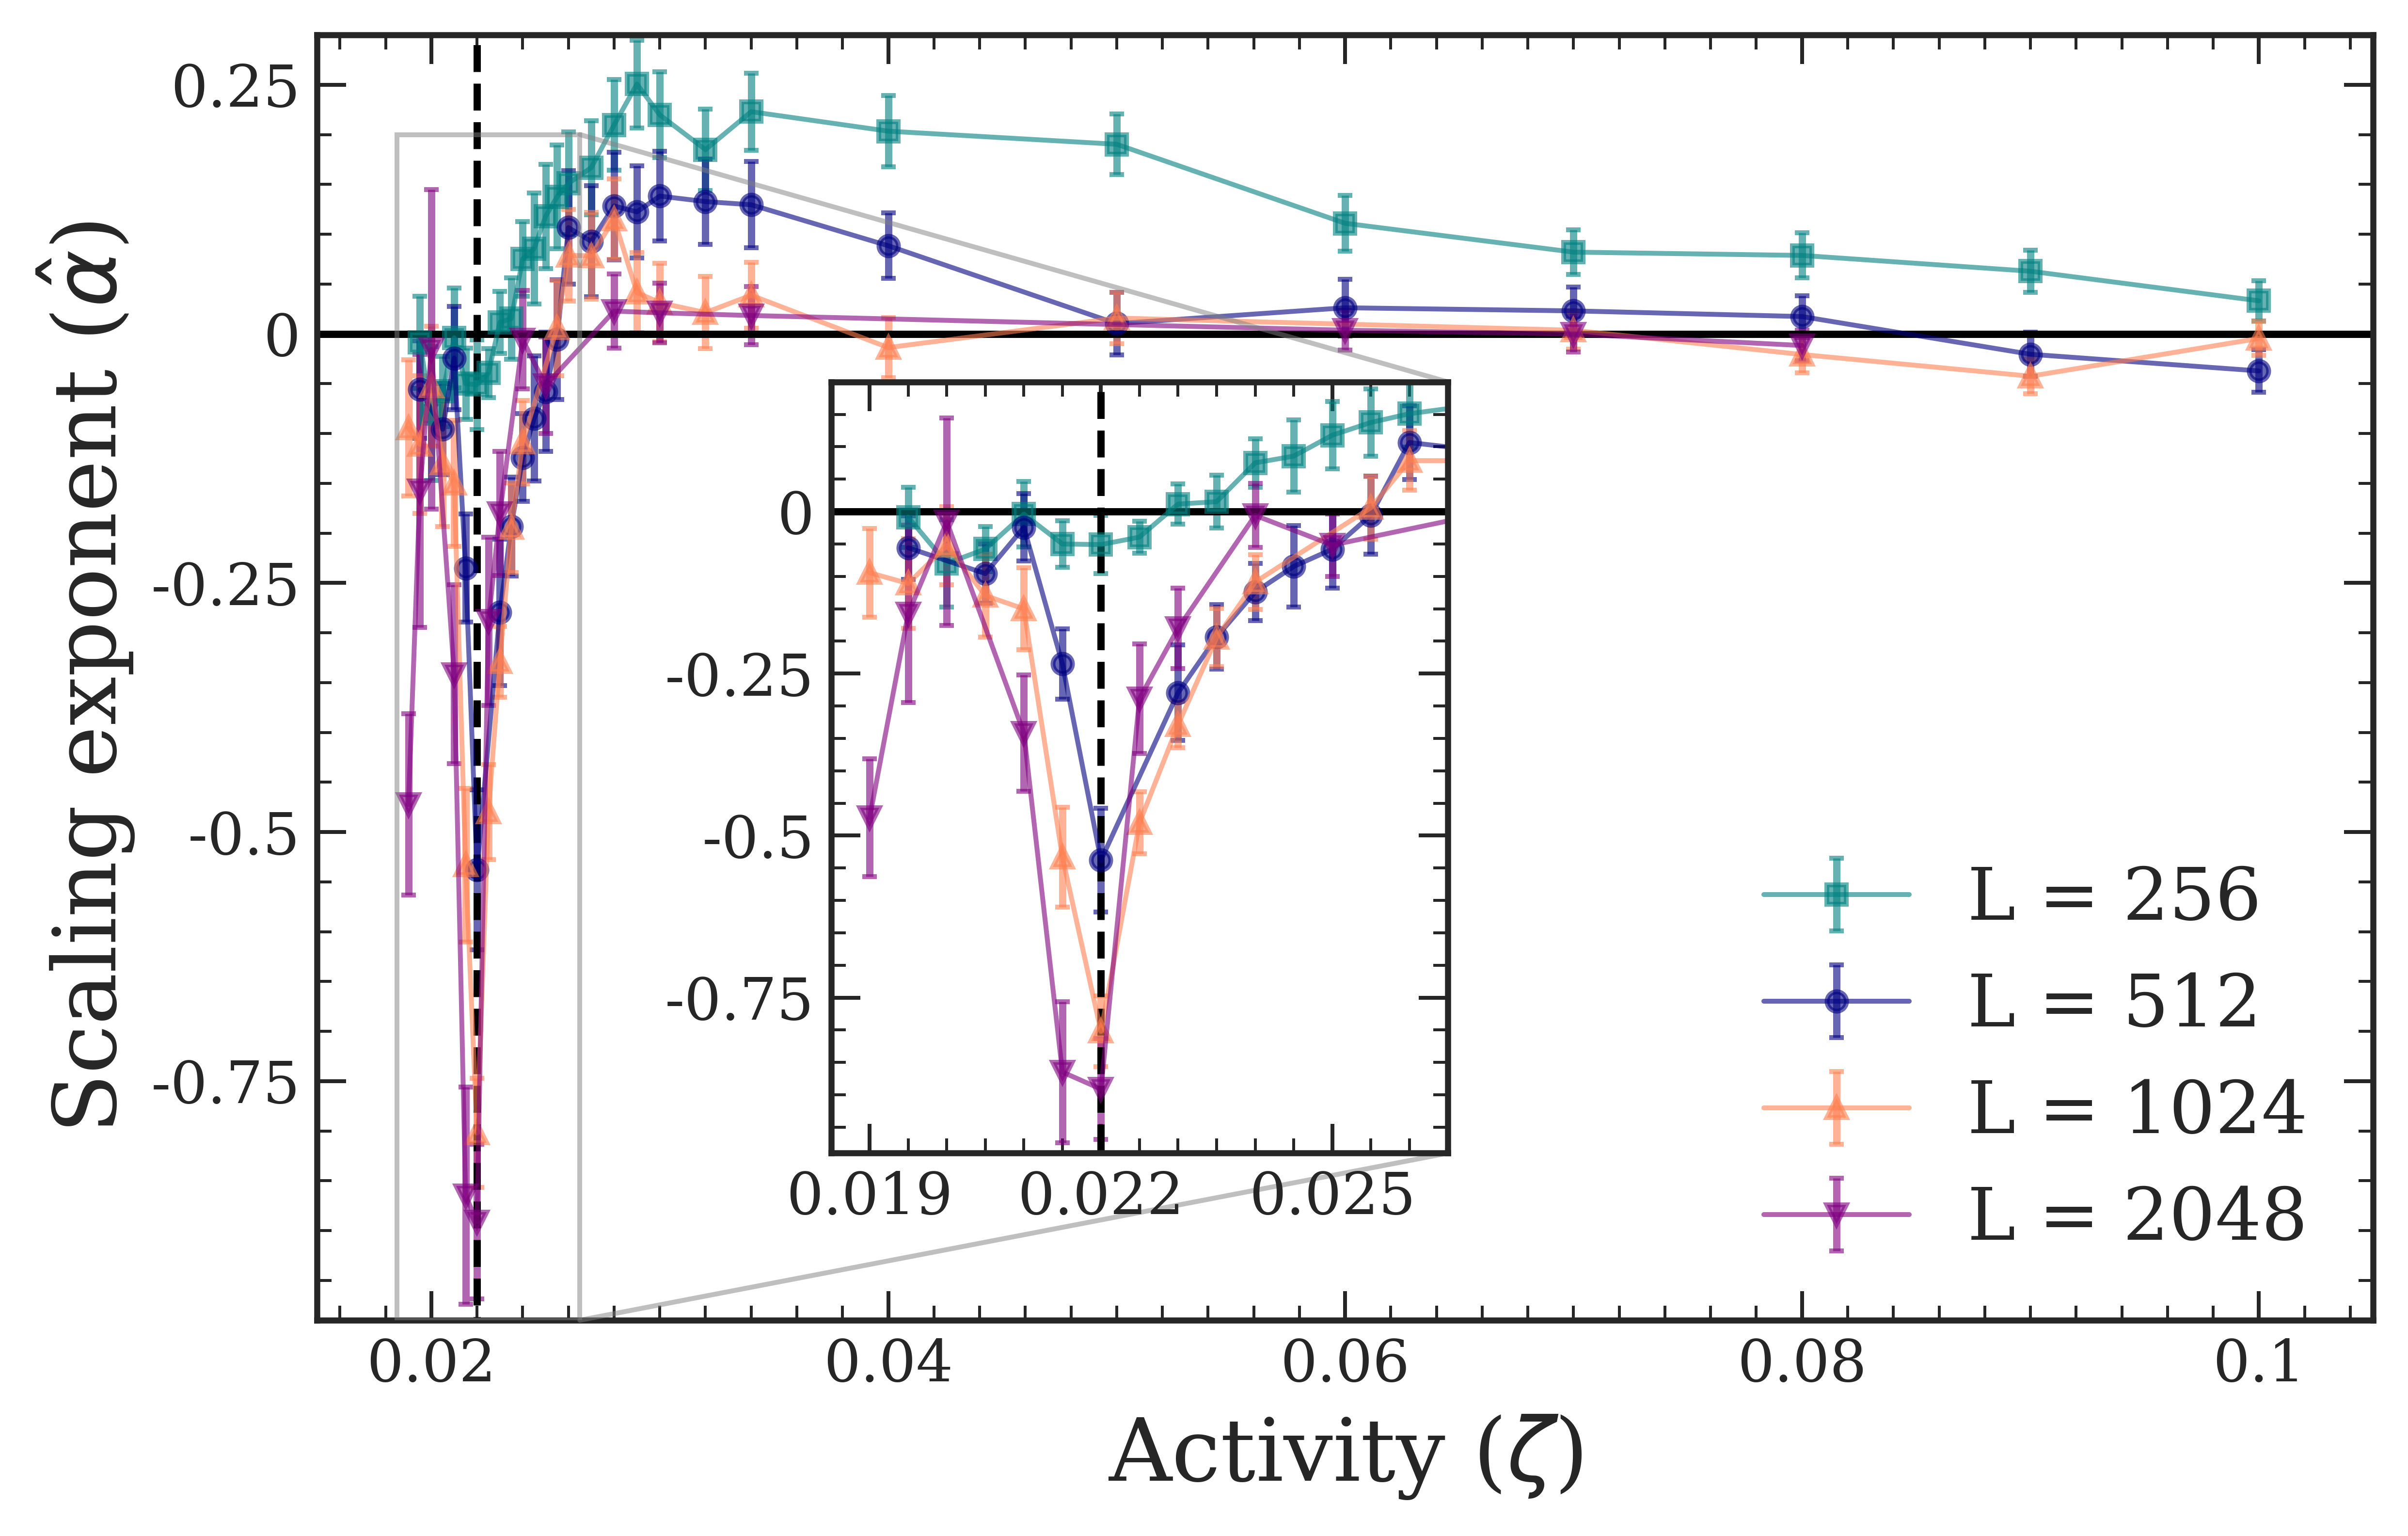

In [86]:

fig, ax = plt.subplots(figsize=(7, 4.5)) 

peak1 = 0.022
peak2 = 0.028

xmin = 0.25
ymin = 0.13
width = 0.3
inset_box = [xmin, ymin,1*width,2*width]

plot_fit_of_time_av = True
ax1, axin1 = ada.plot_alpha_mean_sfac(time_av=plot_fit_of_time_av,  ax = ax, inset_box = inset_box)


ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.99, 0.3]
axin1_xlims = [0.0185, 0.0265] #[0.019, 0.035]
axin1_ylims = [ax1_ylims[0], .2] #[-.82, 0.3]


yticks = [-1.25, -1, -.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-1.25, -1, -.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
axin1_xticks = [0.019, 0.022, 0.025]
ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -2, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '-', alpha = 1)
ax1.indicate_inset_zoom(axin1,)
ax1.set_ylabel(r'Scaling exponent ($\hat{\alpha}$)', labelpad=3)

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axin1.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axin1.xaxis.set_minor_locator(ticker.MultipleLocator(5e-4))


ax.legend()
ax1.set_xlabel(r'Activity ($\zeta$)')
fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)
#fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.84, 1.025))

#axin1.vlines(peak2, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)